# deriving a template spike current

In [1]:
from brian2 import *
import matplotlib.pyplot as plt

In [4]:
num_neurons = 20
spike_threshold = -50*mV
defaultclock.dt = 0.05*ms
codegen.cpp_prefs.compiler = 'msvc'
codegen.cpp_prefs.msvc_vars_location = r'C:\Program Files (x86)\Microsoft Visual Studio\2019\Community\VC\Auxiliary\Build\vcvarsall.bat'

# Parameters
area = 2000*umeter**2 # from Harvard bionumbers
Cm = 1*ufarad*cm**-2 * area
gl = 5e-5*siemens*cm**-2 * area
El = -65*mV
EK = -90*mV
ENa = 50*mV
g_na = 100*msiemens*cm**-2 * area
g_kd = 30*msiemens*cm**-2 * area
VT = -63*mV

tau = 1*ms

# The model
eqs = Equations('''
dv/dt = (gl*(El-v) - g_na*(m*m*m)*h*(v-ENa) - g_kd*(n*n*n*n)*(v-EK) + I)/Cm : volt
dm/dt = 0.32*(mV**-1)*4*mV/exprel((13.*mV-v+VT)/(4*mV))/ms*(1-m)-0.28*(mV**-1)*5*mV/exprel((v-VT-40.*mV)/(5*mV))/ms*m : 1
dn/dt = 0.032*(mV**-1)*5*mV/exprel((15.*mV-v+VT)/(5*mV))/ms*(1.-n)-.5*exp((10.*mV-v+VT)/(40.*mV))/ms*n : 1
dh/dt = 0.128*exp((17.*mV-v+VT)/(18.*mV))/ms*(1.-h)-4./(1+exp((40.*mV-v+VT)/(5.*mV)))/ms*h : 1

dI/dt = (.4*nA * i / num_neurons - I)/tau + .4*nA*xi*tau**-.5: amp
I_tot = (gl*(El-v) - g_na*(m*m*m)*h*(v-ENa) - g_kd*(n*n*n*n)*(v-EK) + I) : amp
''')
# Threshold and refractoriness are only used for spike counting
group = NeuronGroup(num_neurons, eqs,
                    threshold='v > spike_threshold',
                    refractory='v > spike_threshold',
                    method='euler')
group.v = El
group.I = '0.4*nA * i / num_neurons'

sp_mon = SpikeMonitor(group)
st_mon = StateMonitor(group, 'I_tot', range(num_neurons))

run(0.1*second)

BrianObjectException: Error encountered with object named "neurongroup_1_stateupdater".
Object was created here (most recent call only, full details in debug log):
  File "<ipython-input-4-83f80090c193>", line 31, in <module>
    group = NeuronGroup(num_neurons, eqs,

An error occurred when preparing an object. (See above for original error message and traceback.)

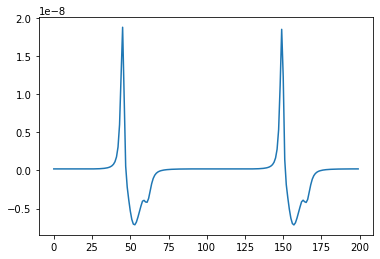

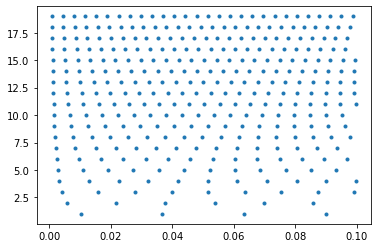

In [118]:
plot(st_mon.I_tot[10, 200:400]); plt.show();
plot(sp_mon.t, sp_mon.i, '.');

Now that we have spikes, let's average them together to get a template spike current:

Averaging over 338 spikes.
[ 3.91872860e-10  4.55878955e-10  5.52815877e-10  7.05897152e-10
  9.61537652e-10  1.42090479e-09  2.32554151e-09  4.29006440e-09
  8.67918455e-09  1.52364429e-08  1.40993192e-08  4.53229290e-09
 -4.74033159e-10 -2.58694686e-09 -4.25104072e-09 -5.64306273e-09
 -6.55248964e-09 -6.92204778e-09 -6.81422349e-09 -6.35151074e-09
 -5.68921960e-09 -4.96745122e-09 -4.30693705e-09 -3.99028749e-09
 -4.03546847e-09 -4.08165716e-09 -3.75439618e-09 -2.96979848e-09
 -2.03792009e-09 -1.27896586e-09 -7.70635600e-10 -4.53092314e-10
 -2.54364503e-10 -1.25904585e-10 -3.93629065e-11  2.14056991e-11
  6.57324286e-11  9.91584810e-11  1.25077221e-10  1.45634222e-10]


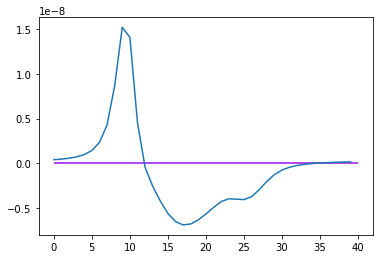

In [116]:
width = 2*ms
dt = defaultclock.dt
template_currents = []
for i, t in zip(sp_mon.i, sp_mon.t):
    if t > st_mon.t[-2] - width:
        break
    template_currents.append(st_mon.I_tot[i, int(t/dt):int(t/dt)+int(width/dt)])

print(f'Averaging over {len(template_currents)} spikes.')    
template = np.average(template_currents, axis=0)
# template = np.hstack((0, template))
plot(template)
plt.hlines(0, 0, len(template), color='xkcd:violet')
print(template)